In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pickle
import itertools
from functions import *

In [11]:
def GetParam(k, d, m=50):
    """ Creates and returns weight matrix W and bias vector b """
    # w1 mxd, w2 kxm, b1 mx1, b2 kx1
    np.random.seed(400)
    w1 = np.random.normal(
        0,
        1/np.sqrt(d),
        (m, d))
    
    w2 = np.random.normal(
        0,
        1/np.sqrt(m),
        (k, m))
    b1 = np.zeros((m, 1))
    b2 = np.zeros((k, 1))
    
    return w1, w2, b1, b2

def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def LoadBatch(filename):
    """ Copied from the dataset website """
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
        
def EvaluateClassifer(X, W1, W2, b1, b2):
    #EVALUATECLASSIFIER that evaluates the network function, i.e. equations
    #(1, 2), on multiple images and returns the results.

    #Each column of X corresponds to an image and it has size dxn
    #W and b are the parameters of the network
    #Each column of P contains the probability for each label for the image 
    #in the corresponding column of X. P has size Kxn
    s1 = np.matmul(W1, X) + b1
    s1[s1<0] = 0
    h = s1
    s2 = np.matmul(W2, h) +b2
    P = softmax(s2)
    return h, P

def ComputeCost(X,Y,W1, W2, b1, b2 , lamb):
    _, P = EvaluateClassifer(X, W1, W2, b1, b2)
    loss = (1/X.shape[1]) * -np.sum(Y*np.log(P))
    j = loss + lamb *(np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return loss, j
    
def ComputeAccuracy(X,y, W1, W2, b1, b2):
    #COMPUTEACCURACY computes the accuracy of the network’s predictions given 
    #by equation (4) on a set of data.
    _, P = EvaluateClassifer(X, W1, W2, b1, b2)
    
    predictions = np.argmax(P, axis =0)
    
    acc = (predictions == y).mean()
    return acc
    
def ComputeGradients(X, Y, W1, W2, b1, b2, n_batch, lamb):
    
        h, P = EvaluateClassifer(X, W1, W2, b1, b2)
        G = -(Y - P)
        
        grad_W2 = (1/n_batch)*np.matmul(G, np.array(h).T) + (2*lamb*W2)
        grad_b2 = np.array((1/n_batch)*np.matmul(G,np.ones(n_batch))).reshape(np.size(W2, 0), 1)

        G = np.matmul(W2.T, G)
        h = np.where(h > 0, 1, 0)
        G = np.multiply(G, h > 0)
        
        grad_W1 = (1/n_batch) * np.matmul(G, np.array(X).T) + (2 * lamb * W1)
        grad_b1 = np.array((1/n_batch)*np.matmul(G, np.ones(n_batch))).reshape(np.size(W1, 0), 1)

        return grad_W1, grad_W2, grad_b1, grad_b2

def gradient_check(grad_w_analyt, grad_w_num, grad_b_analyt, grad_b_num, eps):
    """ Function providing preprocessing for calculating relative error between analytical and numerical gradients """
    checks_w = []
    checks_b = []
    for k in range(len(grad_w_analyt)):
        for d in range(len(grad_w_analyt[k])):
            checks_w.append(np.abs(grad_w_analyt[k][d] - grad_w_num[k][d]) / max(
                eps, (np.abs(grad_w_analyt[k][d]) + np.abs(grad_w_num[k][d]))))

    for k in range(len(grad_b_analyt)):
        checks_b.append(np.abs(grad_b_analyt[k] - grad_b_num[k]) / max(
            eps, (np.abs(grad_b_analyt[k]) + np.abs(grad_b_num[k]))))
    return checks_w, checks_b

def MiniBatchGD(X_train,Y_train,y_train, X_val, Y_val, y_val, W1, W2, b1, b2, lamb, n_epochs = 10, cyclical_eta=False, computations=True):
    
    n_batch = 100
    eta_min = 10**-5
    eta_max = 10**-1
    n = X_train.shape[1]
    n_cycles = 4
    
    J_train = []
    acc_train = []
    loss_train = []
    
    J_val = []
    acc_val = []
    loss_val = []
    
    if cyclical_eta:
        eta = eta_min
        #n_s = 800
        n_s = 2*np.floor(n/n_batch)
        t = 0
        l = 0
        n_epochs = 2*n_cycles*n_s/(n/n_batch)
    else : 
        eta = 0.001

    if computations:
        loss, J = ComputeCost(X_train, Y_train ,W1, W2, b1, b2 , lamb)
        J_train.append(J)
        loss_train.append(loss)

        acc_train.append(ComputeAccuracy(X_train,y_train, W1, W2, b1, b2))

        loss, J = ComputeCost(X_val, Y_val ,W1, W2, b1, b2 , lamb)
        J_val.append(J)
        loss_val.append(loss)

        acc_val.append(ComputeAccuracy(X_val,y_val, W1, W2, b1, b2))
               
    for epoch in range(int(n_epochs)):
        
        for j in range(int(n/n_batch)):
            j_start = j*n_batch
            j_end = (j+1)*n_batch
            #inds = range(j_start, j_end,j_end)
            Xbatch = X_train[:, j_start:j_end]
            Ybatch = Y_train[:, j_start:j_end]
        
            grad_W1, grad_W2, grad_b1, grad_b2 = ComputeGradients(
                Xbatch, Ybatch, W1, W2, b1, b2, n_batch, lamb)

            W1 = W1 -eta*grad_W1
            W2 = W2 - eta*grad_W2
            b1 = b1 - eta*grad_b1
            b2 = b2 - eta*grad_b2

            if cyclical_eta:
                if (2*l*n_s <= t <= (2*l +1)*n_s):
                    eta = eta_min + ((t-2*l*n_s)/n_s)*(eta_max-eta_min)
                else:
                    eta = eta_max - ((t - ((2*l)+1)*n_s)/n_s)*(eta_max-eta_min)
                t+=1

                if ((t%(2*n_s)) == 0):
                    l+=1
                
        if computations:
            loss, J = ComputeCost(X_train, Y_train ,W1, W2, b1, b2 , lamb)
            J_train.append(J)
            loss_train.append(loss)
            
            acc_train.append(ComputeAccuracy(X_train,y_train, W1, W2, b1, b2))
            
            loss, J = ComputeCost(X_val, Y_val ,W1, W2, b1, b2 , lamb)
            J_val.append(J)
            loss_val.append(loss)
            
            acc = ComputeAccuracy(X_val,y_val, W1, W2, b1, b2)
            acc_val.append(acc)
         
        #Print stuff
        print("----- Epoch " + str(int(epoch + 1)) + " out of " + str(int(n_epochs)) + "-------")
        if computations:
            print("Cost on validation = " + str(J))
            print("Loss on validation = " + str(loss))
            print("Accuracy on validation = " + str(acc))
        
        
    return J_train, loss_train, J_val, loss_val, acc_train, acc_val, W1, W2, b1, b2, n_epochs

def Init(alldata = False):
    
    if alldata:
        
        data1 = LoadBatch("./cifar-10-batches-py/data_batch_1")
        data2 = LoadBatch("./cifar-10-batches-py/data_batch_2")
        data3 = LoadBatch("./cifar-10-batches-py/data_batch_3")
        data4 = LoadBatch("./cifar-10-batches-py/data_batch_4")
        data5 = LoadBatch("./cifar-10-batches-py/data_batch_5")
        data6 = LoadBatch("./cifar-10-batches-py/test_batch")
        
        X = np.concatenate((data1[b'data'], data2[b'data'], data3[b'data'],
                            data4[b'data'], data5[b'data'], data6[b'data']))


        y = np.concatenate((data1[b'labels'], data2[b'labels'], data3[b'labels'],
                            data4[b'labels'], data5[b'labels'], data6[b'labels']))
        
        # One Hot encode Y
        Y = np.eye(max(y) + 1)[y]

        # Center X
        mean_X = np.mean(X, 0)
        std_X = np.std(X, 0)

        X = (X - mean_X)/std_X
        # %%
        #Train
        train_y = y[:49000]
        train_Y = Y[:49000]
        train_X = X[:49000]


        #Validation
        validation_y = y[49000:50000]
        validation_Y = Y[49000:50000]
        validation_X = X[49000:50000]

        #Test
        test_y = y[50000:]
        test_Y = Y[50000:]
        test_X = X[50000:]
        
        d = train_X.shape[1]
        K = train_Y.shape[1]

        W1, W2, b1, b2 = GetParam(10, train_X.shape[1])
        
        return train_X.T, train_Y.T, train_y.T ,validation_X.T, validation_Y.T,validation_y.T,test_X.T, test_Y.T, test_y.T, W1, W2, b1, b2
        
    else:
        
        data1 = LoadBatch("./cifar-10-batches-py/data_batch_1")
        data2 = LoadBatch("./cifar-10-batches-py/data_batch_2")
        data6 = LoadBatch("./cifar-10-batches-py/test_batch")


        X = np.concatenate((data1[b'data'], data2[b'data'], data6[b'data']))


        y = np.concatenate((data1[b'labels'], data2[b'labels'], data6[b'labels']))
        # One Hot encode Y
        Y = np.eye(max(y) + 1)[y]

        # Center X
        mean_X = np.mean(X, 0)
        std_X = np.std(X, 0)

        X = (X - mean_X)/std_X
        # %%
        #Train
        train_y = y[:10000]
        train_Y = Y[:10000]
        train_X = X[:10000]


        #Validation
        validation_y = y[10000:20000]
        validation_Y = Y[10000:20000]
        validation_X = X[10000:20000]

        #Test
        test_y = y[20000:]
        test_Y = Y[20000:]
        test_X = X[20000:]
                
        W1, W2, b1, b2 = GetParam(10, train_X.shape[1])
        
        return train_X.T, train_Y.T, train_y.T ,validation_X.T, validation_Y.T,validation_y.T,test_X.T, test_Y.T, test_y.T, W1, W2, b1, b2

def plot(J_train, J_val, loss_train, loss_val, acc_train, acc_val, acc_test, epochs, plot_test = False):
    
    epochs_label = np.arange(0, epochs+1, 1)
    #print(J_train)
    #print(epochs_label)
    #Plot Cost function 
    plt.plot(epochs_label, J_train, label="Training Data")
    plt.plot(epochs_label, J_val, label="Validation Data")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Cost') 
    plt.ylim(0, 4) 
    plt.xlim(0, epochs)
    plt.grid()
    
    plt.show()
    
    
    #Plot Loss function
    plt.plot(epochs_label, loss_train, label="Training Data")
    plt.plot(epochs_label, loss_val, label="Validation Data")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.ylim(0, 3) 
    plt.xlim(0, epochs)
    plt.grid()
    
    plt.show()
    
    
    #Plot Accuracy
    
    plt.plot(epochs_label, acc_train, label="Training Accuracy")
    plt.plot(epochs_label, acc_val, label="Validation Accuracy")
    if plot_test:
        plt.plot(epochs, acc_test, marker = 'o', markersize = 6, label ="Test Accuracy")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy') 
    plt.ylim(0, 0.8) 
    plt.xlim(0, epochs)
    plt.grid()
    
    plt.show()

def optimize_lambda(l_min, l_max, X_train, Y_train, y_train, X_val, Y_val, y_val, W1, W2, b1, b2, ite = 8):
    
    values = []
    
    for i in range(int(ite)):
        print ("---> Iteration no : " + str(i))
        
        lamb = np.random.uniform(l_min, l_max);
        print("lamb = " + str(lamb))
        
        _, _, _, _, _, _, W1, W2, b1, b2, n_epochs = MiniBatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, 
                                                                W1, W2, b1, b2, lamb, cyclical_eta=True, 
                                                                 computations=True)
        
        _, cost = ComputeCost(X_val, Y_val ,W1, W2, b1, b2 , lamb)
        acc_val = ComputeAccuracy(X_val, y_val, W1, W2, b1, b2)
        print("\n lamb---cost---acc_val")
        values.append([lamb, cost, acc_val])
        
    for value in values:
        print(value)
 

----- Epoch 1 out of 16-------
Cost on validation = 2.0133154229766514
Loss on validation = 1.6236136118248359
Accuracy on validation = 0.45
----- Epoch 2 out of 16-------
Cost on validation = 1.762225415156846
Loss on validation = 1.575794841293472
Accuracy on validation = 0.441
----- Epoch 3 out of 16-------
Cost on validation = 1.6282157900558174
Loss on validation = 1.4780240624706922
Accuracy on validation = 0.484
----- Epoch 4 out of 16-------
Cost on validation = 1.5643000143588746
Loss on validation = 1.4142571857946933
Accuracy on validation = 0.507
----- Epoch 5 out of 16-------
Cost on validation = 1.6083164079133838
Loss on validation = 1.4545677396220802
Accuracy on validation = 0.488
----- Epoch 6 out of 16-------
Cost on validation = 1.7055755788057292
Loss on validation = 1.551151528081254
Accuracy on validation = 0.461
----- Epoch 7 out of 16-------
Cost on validation = 1.596188163272643
Loss on validation = 1.4392804033580306
Accuracy on validation = 0.496
----- Epoch

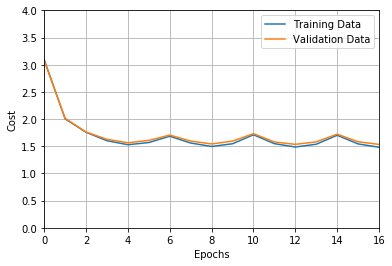

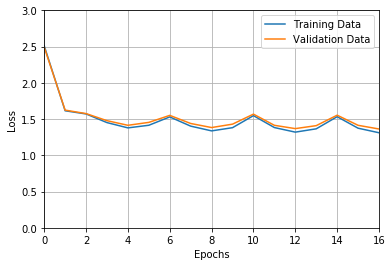

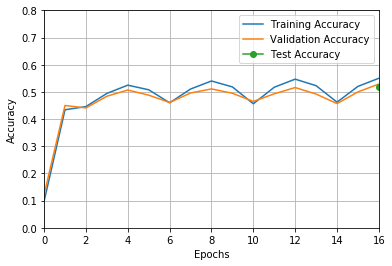

In [12]:
def main(alldata = True, ploty = True):
    
    X_train, Y_train, y_train ,X_val, Y_val, y_val, X_test, Y_test, y_test, W1, W2, b1, b2 = Init(alldata)
    
    lamb = 0.00973 #Best lambda find with coarse-to-fine random search
    
    J_train, loss_train, J_val, loss_val, acc_train, acc_val, W1, W2, b1, b2, n_epochs = MiniBatchGD(
        X_train, Y_train, y_train, X_val, Y_val, y_val, W1, W2, b1, b2, 
        lamb, n_epochs = 10, cyclical_eta=True, computations=True)
    
    acc_test = ComputeAccuracy(X_test, y_test, W1, W2, b1, b2)
    print(" Result Final accuracy on test set : " + str(acc_test*100) +" %")
    
    if ploty:
        plot(J_train, J_val, loss_train, loss_val, acc_train, acc_val, acc_test, n_epochs,plot_test=True)

if __name__ == "__main__":
    main()

In [22]:
X_train, Y_train, y_train ,X_val, Y_val, y_val, X_test, Y_test, y_test, W1, W2, b1, b2 = Init(True)
W2.shape

(10, 50)

In [ ]:
 #Optimize lambda : coarse search between 10^-1 and 10^-5
    
print("Coarse result : best lambda 1 = 0.01785 / Accuracy on validation set 1 = 0.4940")
print("Coarse result : best lambda 2 = 0.02222 / Accuracy on validation set 2 = 0.4876")
print("Coarse result : best lambda 3 = 0.01424 / Accuracy on validation set 3 = 0.4980")

lamb_max = 0.1
lamb_min = 10**-5

X_train, Y_train, y_train ,X_val, Y_val, y_val, _, _, _, W1, W2, b1, b2 = Init(alldata = True)

optimize_lambda(lamb_min, lamb_max, X_train, Y_train, y_train, X_val, Y_val, y_val, W1, W2, b1, b2)

In [25]:
#Optimize lambda fine search
print("Coarse result : best lambda 1 = 0.01299 / Accuracy on validation set 1 = 0.513")
print("Coarse result : best lambda 2 = 0.01134 / Accuracy on validation set 2 = 0.5094")
print("Coarse result : best lambda 3 = 0.01022 / Accuracy on validation set 3 = 0.5152")

X_train, Y_train, y_train ,X_val, Y_val, y_val, _, _, _, W1, W2, b1, b2 = Init(alldata = True)
lamb_min = 0.0095
lamb_max = 0.012

optimize_lambda(lamb_min, lamb_max, X_train, Y_train, y_train, X_val, Y_val, y_val, W1, W2, b1, b2)

Coarse result : best lambda 1 = 0.01299 / Accuracy on validation set 1 = 0.513
Coarse result : best lambda 2 = 0.01134 / Accuracy on validation set 2 = 0.5094
Coarse result : best lambda 3 = 0.01022 / Accuracy on validation set 3 = 0.5152
---> Iteration no : 0
lamb = 0.011038567697521715
----- Epoch 1 out of 8-------
Cost on validation = 2.105928408989163
Loss on validation = 1.672931500544571
Accuracy on validation = 0.4102
----- Epoch 2 out of 8-------
Cost on validation = 1.8257156697002177
Loss on validation = 1.6317188848962703
Accuracy on validation = 0.4192
----- Epoch 3 out of 8-------
Cost on validation = 1.6821585628049718
Loss on validation = 1.5292516774478238
Accuracy on validation = 0.4664
----- Epoch 4 out of 8-------
Cost on validation = 1.6168471152724642
Loss on validation = 1.4633024152997927
Accuracy on validation = 0.494
----- Epoch 5 out of 8-------
Cost on validation = 1.6690461486225463
Loss on validation = 1.5129189984912554
Accuracy on validation = 0.4764
----

----- Epoch 6 out of 8-------
Cost on validation = 1.72045021555773
Loss on validation = 1.5430281705090507
Accuracy on validation = 0.4516
----- Epoch 7 out of 8-------
Cost on validation = 1.6221594264524986
Loss on validation = 1.44471957935674
Accuracy on validation = 0.4948
----- Epoch 8 out of 8-------
Cost on validation = 1.5540478338153743
Loss on validation = 1.3744599620153135
Accuracy on validation = 0.5226

 lamb---cost---acc_val
---> Iteration no : 7
lamb = 0.00988097674531387
----- Epoch 1 out of 8-------
Cost on validation = 1.6299440501120381
Loss on validation = 1.4441846772805238
Accuracy on validation = 0.4996
----- Epoch 2 out of 8-------
Cost on validation = 1.712907509011601
Loss on validation = 1.532490471386382
Accuracy on validation = 0.4522
----- Epoch 3 out of 8-------
Cost on validation = 1.6291849725091203
Loss on validation = 1.4493791734770134
Accuracy on validation = 0.4974
----- Epoch 4 out of 8-------
Cost on validation = 1.5562095802995948
Loss on val